In [ ]:
! pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.8 MB/s eta 0:00:00


In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes

In [ ]:
import os

HFCOMPANY=os.environ.get("HFCOMPANY", "cryptic-wordplay-formalizer")

In [ ]:
from datasets import load_dataset
dataset = load_dataset("boda/cryptonite")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher'],
        num_rows: 470804
    })
    val: Dataset({
        features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher'],
        num_rows: 26156
    })
    test: Dataset({
        features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher'],
        num_rows: 26157
    })
})

In [ ]:
dataset['train'][110]

{'publisher': 'Times',
 'date': Timestamp('2000-10-20 00:00:00'),
 'author': '',
 'orientation': 'down',
 'clue': 'keep an eye on new technology in an uncultivated environment (7)',
 'answer': 'monitor',
 'enumeration': '(7)',
 'quick': False,
 'sub_publisher': 'The Times'}

In [ ]:
def transform_to_text(example):
    clue = example['clue']
    answer = example['answer']
    enumeration = example['enumeration']
    orientation = example['orientation']

    system = f"""You are a Master Cryptic Crossword player take the following clue and think carefully to come up with the correct answer"""
    user = f'''CLUE: {clue} \n ORIENTATION: the word is {enumeration} letters long and goes {orientation}\n'''.lstrip()
    assistant = f'''ANSWER: {answer}'''

    text = f'''<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>

{user}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n{assistant}<|eot_id|><|end_of_text|>'''

    return {'answer': answer, 'text': text,
          'system': system, 'user': user, 'assistant':assistant}

# Apply the transformationt
transformed_dataset = dataset.map(transform_to_text)

In [ ]:
transformed_dataset

DatasetDict({
    train: Dataset({
        features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher', 'text', 'system', 'user', 'assistant'],
        num_rows: 470804
    })
    val: Dataset({
        features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher', 'text', 'system', 'user', 'assistant'],
        num_rows: 26156
    })
    test: Dataset({
        features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher', 'text', 'system', 'user', 'assistant'],
        num_rows: 26157
    })
})

## Check Lengths

In [ ]:
transformed_dataset['train'] = transformed_dataset['train'].add_column(
    'length', [len(x.split(' ')) for x in transformed_dataset['train']['text']]
)

In [ ]:
transformed_dataset['train']

Dataset({
    features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher', 'text', 'system', 'user', 'assistant', 'length'],
    num_rows: 470804
})

<Axes: >

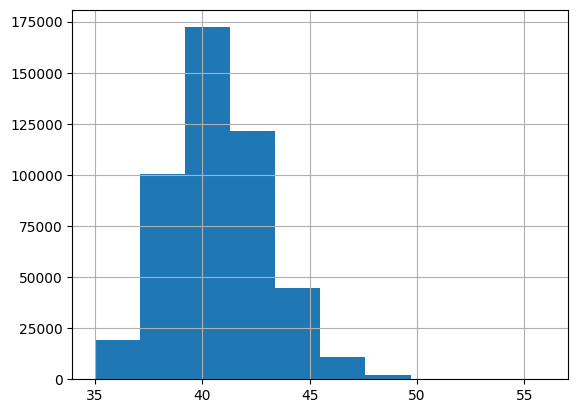

In [ ]:
# transformed_dataset['train'].hist("length", bins=10);

import pandas as pd

# Convert the 'train' dataset to a pandas DataFrame
df = pd.DataFrame(transformed_dataset['train'])

# Create a histogram of the 'length' column
df['length'].hist(bins=10)

## FT Llama3

In [ ]:
from unsloth import FastLanguageModel
import torch
# max_seq_length = 64
dtype = None # auto detection.
load_in_4bit = True

fourbit_models = [
    "unsloth/llama-3-8b-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 42,
    use_rslora = False,
    loftq_config = None,
)

In [ ]:
transformed_dataset['train']

Dataset({
    features: ['publisher', 'date', 'author', 'orientation', 'clue', 'answer', 'enumeration', 'quick', 'sub_publisher', 'text', 'system', 'user', 'assistant', 'length'],
    num_rows: 470804
})

In [ ]:
transformed_dataset['train'][0]['text']

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a Master Cryptic Crossword player take the following clue and think carefully to come up with the correct answer<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\n\nCLUE: make progress socially in stated region (5) \n ORIENTATION: the word is (5) letters long and goes across\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nANSWER: climb<|eot_id|><|end_of_text|>'

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

max_seq_length = 128

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = transformed_dataset['train'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True, # worth trying for
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 100,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 42,
        output_dir = "outputs",
    ),
)

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 289,609 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 4
\        /    Total batch size = 128 | Total steps = 2,262
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
5,3.332300
10,1.994300
15,1.224200
20,1.020800
25,0.901900
30,0.850100
35,0.829200
40,0.826200
45,0.806900
50,0.787600


In [ ]:
# trainer_stats = trainer.train()

In [ ]:
prompt_test = transformed_dataset['train'][0]['text']

prompt_test

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a Master Cryptic Crossword player take the following clue and think carefully to come up with the correct answer<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\n\nCLUE: make progress socially in stated region (5) \n ORIENTATION: the word is (5) letters long and goes across\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nANSWER: climb<|eot_id|><|end_of_text|>'

In [ ]:
prompt_to_use = '''<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a Master Cryptic Crossword player take the following clue and think carefully to come up with the correct answer<|eot_id|>
<|start_header_id|>user<|end_header_id|>

CLUE: make progress socially in stated region (5)
 ORIENTATION: the word is (5) letters long and goes across
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
'''

In [ ]:
# inference
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer([prompt_to_use], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs,
                         max_new_tokens = 64,
                         use_cache = True,)

tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a Master Cryptic Crossword player take the following clue and think carefully to come up with the correct answer<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\n\nCLUE: make progress socially in stated region (5)\n ORIENTATION: the word is (5) letters long and goes across\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nANSWER: area<|eot_id|><|end_of_text|>']

In [ ]:
# local save
model.save_pretrained("llama3_cryptonite_1_epoch")
tokenizer.save_pretrained("llama3_cryptonite_1_epoch")

('llama3_cryptonite_1_epoch/tokenizer_config.json',
 'llama3_cryptonite_1_epoch/special_tokens_map.json',
 'llama3_cryptonite_1_epoch/tokenizer.json')

In [ ]:
# HF save
model.push_to_hub(f"{HFCOMPANY}/llama3_cryptonite_1_epoch", private=True)
tokenizer.push_to_hub(f"{HFCOMPANY}/llama3_cryptonite_1_epoch", private=True)

## Loading the inference from HF

In [ ]:
prompt_test = transformed_dataset['train'][3]['text']

prompt_test

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a Master Cryptic Crossword player take the following clue and think carefully to come up with the correct answer<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\n\nCLUE: idle fellow, but he gives us a buzz (5) \n ORIENTATION: the word is (5) letters long and goes across\n<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nANSWER: drone<|eot_id|><|end_of_text|>'

In [ ]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"{HFCOMPANY}/llama3_cryptonite_test_100_steps",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Faster inference


inputs = tokenizer([prompt_test], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 512, use_cache = True)
tokenizer.batch_decode(outputs)

adapter_config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Cryptic clue wordplay to python : complete the following proof, adding wordplay to the docstring, and corresponding asserts to the function:\ndef proof(answer="NANAS", clue="Old relatives\xa0which featured on Hey Jude?", pattern=\'5\'):\n  """\n  definition: {Old relatives}\xa0which featured on Hey Jude?\n  wordplay:  Double definition\n  """\n  assert is_synonym("Old relatives", "NANAS", pattern=\'5\')\n\ndef proof(answer="NANAS", clue="Old relatives\xa0which featured on Hey Jude?", pattern=\'5\'):\n  """\n  definition: {Old relatives}\xa0which featured on Hey Jude?\n  wordplay:  Double definition\n  """\n  assert is_synonym("Old relatives", "NANAS", pattern=\'5\')\n\ndef proof(answer="NANAS", clue="Old relatives\xa0which featured on Hey Jude?", pattern=\'5\'):\n  """\n  definition: {Old relatives}\xa0which featured on Hey Jude?\n  wordplay:  Double definition\n  """\n  assert is_synonym("Old relatives", "NANAS", pattern=\'5\')\n\ndef proof(answer="NANAS", clue="Old